In [2]:
#!wget -O masterarbeit.zip https://drive.google.com/file/d/17BfPVH-KCRyJUCADjZpoVs9iLmYO1VlR/view?usp=sharing
#!unzip  masterarbeit.zip

In [3]:
import torch
import torchaudio
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Audio
from IPython.display import clear_output, display
import json
import librosa
import librosa.display as dsp
import math
import datetime
import time
import numpy as np
#import pedalboard
import pyloudnorm as pyln
import warnings
import ast
import tarfile

In [4]:
#AMP to DB und umgekehrt
def amp_to_db(tensor):
    return tensor.log10() * 20

def db_to_amp(tensor):
    return 10.0**(0.5 * tensor/10)

#Berechnet RMS
def rms(tensor):
    tensor = tensor.square()
    tensor = tensor.mean(dim=-1)
    tensor = tensor.sqrt()
    return tensor

def db(tensor):
    return amp_to_db(rms(tensor))

In [5]:
#Pfad zu Datei

# Theoretisch wäre es möglich die csv in den Parameter data einzulesen
# dann wird aber automatisch data immer über schrieben, wenn beides (aus irgendeinem Grund übergeben wird)
# das will ich aber nicht
class BaseDataset(Dataset):
    def __init__(self, csv_file = None, data = None, target_samplerate=16000) -> None:
        super().__init__()

        #Speichert Data direkt
        if data is not None:
            
            if "filename" not in data.columns:
                raise Exception ("Bad Data Format")
            
            self.data = data

        #Lädt Csv
        elif csv_file is not None:
            
            data = pd.read_csv(csv_file)

            if "filename" not in data.columns:
                raise Exception ("Bad Data Format")
            
            self.data = data
        
        #Für Transforms
        self.target_samplerate = target_samplerate

    def __len__(self):
        return len(self.data)

    def __getitem__(self, n):

        #lädt Zeile
        row = self.data.iloc[n]

        #lädt Datei
        waveform, sample_rate = librosa.load(self.__getfile__(row.filename), sr=self.target_samplerate, mono=True, dtype="float64")

        #Tensor
        waveform = torch.from_numpy(waveform).to(torch.float32)

        #Return
        return waveform, self.target_samplerate, row
        
    #Abstract
    def __getfile__(self, filename):
        raise Exception("__getfile__ not implemented")
    
    def check_files(self, rms_treshhold = 0.001):
        try:
            for waveform, _, row in self:
                if rms(waveform) < rms_treshhold:
                    raise Exception(f"{row.filename} has rms < {rms_treshhold}")
        
        except Exception as e:
            print(e)

class LocalFileDataset(BaseDataset):
    def __init__(self, root_dir, csv_file=None, data=None, target_samplerate=16000) -> None:
        
        #Verzeichnissordner
        self.root_dir    = root_dir

        #Erstellt DataFrame aus Datein im Ordner
        if csv_file is None and data is None:
            files = [entry.name for entry in os.scandir(self.root_dir)]
            df    = pd.DataFrame({"filename" : files})
            df    = df[df.filename.str.contains("wav|mp3|ogg|flac")]
            data  = df
        
        #Super
        super().__init__(csv_file, data, target_samplerate)

    def __getfile__(self, filename):
        return os.path.join(self.root_dir, filename)

class TarDataset(BaseDataset):
    def __init__(self, tar_file, csv_file=None, data=None, target_samplerate=16000) -> None:
        
        #Tar
        self.tar_file         = tar_file
        self.tar_file_handler = None

        #Super
        super().__init__(csv_file, data, target_samplerate)

    #Öffnet Datei
    def open(self):
        if self.tar_file_handler is None:
            self.tar_file_handler = tarfile.open(self.tar_file, mode="r")
    
    def close(self):
        if self.tar_file_handler is not None:
            self.tar_file_handler.close()
    
    def __getfile__(self, filename):
        #opens file
        if self.tar_file_handler is None:
            self.open()

        #liest teil
        member = self.tar_file_handler.getmember(filename)
        return self.tar_file_handler.extractfile(member)
    
    def __del__(self):
        self.close()

In [6]:
#Konstante
SAMPLE_RATE = 16000

#Lädt CSV
train_csv = pd.read_csv(r"./Data/train.csv")
test_csv  = pd.read_csv(r"./Data/test.csv")
train_csv["voice"] = train_csv["voice"].apply(ast.literal_eval)
test_csv["voice"]  = test_csv["voice"].apply(ast.literal_eval)

#Dataset
file_dataset_train = LocalFileDataset(r"D:\Masterarbeit\SAMPLES GENERATED",      data=train_csv, target_samplerate=SAMPLE_RATE)
file_dataset_test  = LocalFileDataset(r"D:\Masterarbeit\SAMPLES GENERATED TEST", data=test_csv,  target_samplerate=SAMPLE_RATE)

In [7]:
%%timeit
for i in np.random.randint(0, len(file_dataset_train), size=1000):
    waveform, sr, _ = file_dataset_train[i]

24.1 s ± 409 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
file_dataset_train = TarDataset(r"D:/Masterarbeit/train.tar", data=train_csv, target_samplerate=SAMPLE_RATE)
file_dataset_test  = TarDataset(r"D:/Masterarbeit/test.tar",  data=test_csv,  target_samplerate=SAMPLE_RATE)

In [9]:
%%timeit
for i in np.random.randint(0, len(file_dataset_train), size=1000):
    waveform, sr, _ = file_dataset_train[i]

10.8 s ± 717 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


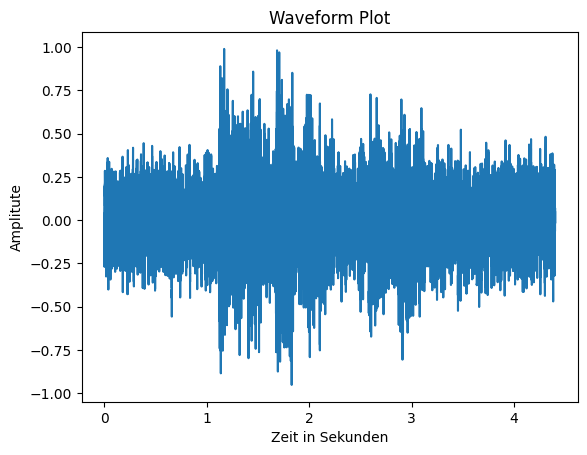

In [31]:
def plot_waveform(waveform, sr, y_axis_0dbfs_scale = False):

    #x-Achse
    time_axis = torch.arange(0,waveform.shape[-1]) / sr

    #y-Achse
    y = waveform

    plt.plot(time_axis,y)
    plt.xlabel("Zeit in Sekunden")
    plt.ylabel("Amplitute")

    #Y Axe zwischen -1 und 1
    if y_axis_0dbfs_scale:
        plt.ylim((-1,1))

    plt.title("Waveform Plot")

#PLOT
plot_idx = 1233
tensor, sr, _ = file_dataset_train[plot_idx]
plot_waveform(tensor,sr)

In [32]:
#KONSTANTEN
#SAMPLE_LENGTH = 0.03
#HOP_LENGTH    = 0.02

#SAMPLE_LENGTH = librosa.time_to_samples(SAMPLE_LENGTH, sr=SAMPLE_RATE)
#HOP_LENGTH    = librosa.time_to_samples(HOP_LENGTH,    sr=SAMPLE_RATE)

SAMPLE_LENGTH = 512
HOP_LENGTH    = 256

#erzeugt 30 ms Samples aus der geladenen Datei
@torch.no_grad()
def get_samples(waveform, sample_length = SAMPLE_LENGTH, hop_length = HOP_LENGTH):
    
    #Sichert das der Übergebense Tensor die Form[Datenpunkt]
    if len(waveform.shape) != 1:
        raise Exception("BAD TENSOR SHAPE")
    
    #Erzeugt Samples
    return waveform.unfold(0, size = sample_length, step = hop_length)

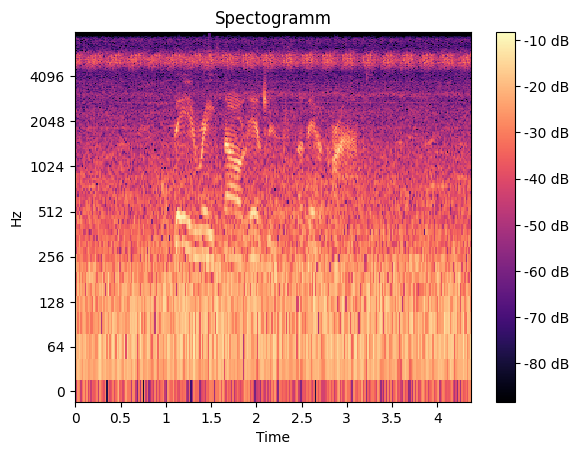

In [33]:
def plot_spectorgram(tensor, sr):
    
    #Cast
    if hasattr (tensor,"numpy"):
        values = tensor.numpy()
    
    else:
        values = tensor
    
    #Werte
    window    = np.hanning(SAMPLE_LENGTH)
    stft      = librosa.stft(y=values, n_fft=SAMPLE_LENGTH,hop_length=HOP_LENGTH, window=window, center=False)
    magnitude = np.abs(stft)
    dbfs      = librosa.amplitude_to_db(2 * magnitude / sum(window), ref=1)

    #Plot
    spec = librosa.display.specshow(dbfs, y_axis='log', sr=sr, hop_length=HOP_LENGTH, x_axis='time')
    plt.colorbar(spec, format="%+2.f dB")

    plt.title("Spectogramm")
    plt.show()

plot_idx = 1233
tensor, sr, _ = file_dataset_train[plot_idx]
plot_spectorgram(tensor,sr)

In [34]:
#Liefert zusammenhängende Parts zurück
def get_parts(tensor):

    #Für Return
    parts = []

    #Für 
    start = 0
    end   = 0
    searching = False
    
    for idx, value in enumerate(tensor > 0.5):
        #Sucht nach neuem Part
        if value:
            if not searching:
                start     = idx
                end       = idx
                searching = True
            else:
                end = idx
        
        else:
            #Erstellt neuen Part
            if searching:
                searching = False
                parts.append((start,end))
    
    #Falls Part bis zum Ende geht
    if searching:
        parts.append((start, end))
    
    return parts

In [37]:
def get_y(tensor,sr,info):
    out = torch.zeros_like(tensor)
    out[info["voice"][0] : info["voice"][1] + 1] = 1
    return out

In [38]:
def plot_waveform_non_silent(waveform, non_silent,sr):

    #Plot Tensor
    plot_waveform(waveform,sr)

    #Plot
    for start, end in get_parts(non_silent):
        plt.axvspan(
            xmin = librosa.samples_to_time(start, sr=sr),
            xmax = librosa.samples_to_time(end  , sr=sr),
            alpha=0.1, color="green"
        )

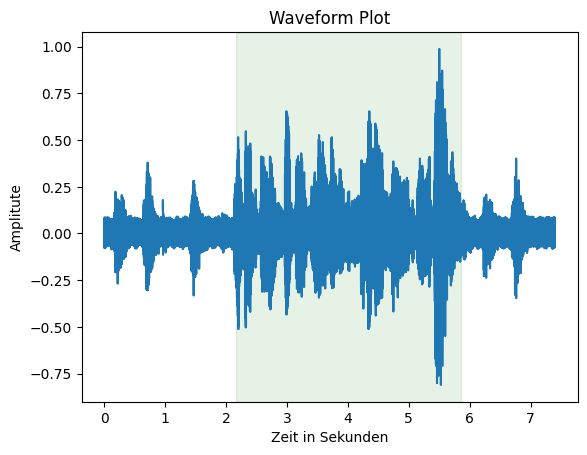

In [39]:
plot_idx = 53
tensor, sr, info = file_dataset_train[plot_idx]
plot_waveform_non_silent(tensor, get_y(tensor, sr, info), sr=sr)

Text(0.5, 1.0, 'Samples Plot')

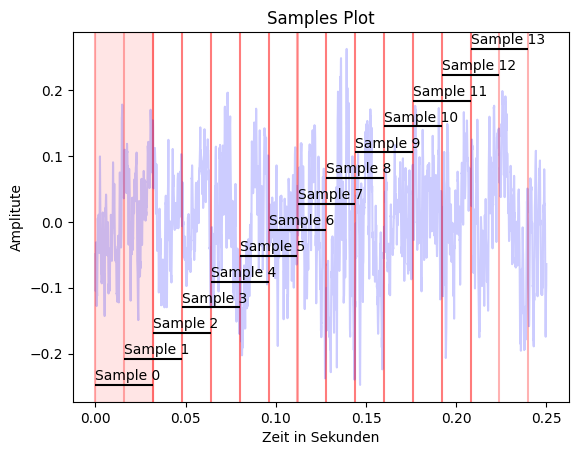

In [40]:
#BSP-Plot
plot_length = 0.25

plot_idx = 51
tensor, sr, _ = file_dataset_train[plot_idx]

#x-Achse
time_axis = torch.arange(0,librosa.time_to_samples(plot_length,sr=SAMPLE_RATE)) / sr
time_axis.numpy()

#y-Achse
y = tensor[:time_axis.shape[-1]].numpy()

#Plottet Waveform
plt.plot(time_axis,y, color="blue", alpha=0.2)

#Plottet Samples
plot_data = get_samples((time_axis))

y_max     = y.max()
y_min     = y.min()
n_samples = plot_data.shape[0]

for idx, sample in enumerate(plot_data):

    #Start und Ende
    start = sample[0]
    end   = sample[-1]
    
    #Plottet horizontale  Rote Linie
    plt.axvline(start, color="red", alpha=0.3, zorder = 1)
    plt.axvline(end,   color="red", alpha=0.3, zorder = 1)

    #Plottet schwarzen Strich mit Label Sample X
    sample_line_hight = y_min + abs(y_max - y_min) * idx / (n_samples - 1)
    plt.hlines(sample_line_hight, start, end, color="black")
    plt.annotate(f"Sample {idx}",(start, sample_line_hight), textcoords="offset pixels", xytext=(0,5))

    #plottet für ersen Idx noch den Hintergrund
    if idx == 0:
        plt.axvspan(xmin = start, xmax = end, alpha=0.1,color="red", label="Sample Länge")

plt.xlabel("Zeit in Sekunden")
plt.ylabel("Amplitute")
plt.title("Samples Plot")

In [41]:
#Funtkion zum Normalisieren der 
def normalize_waveform_to_peak(waveform, peak = -0.1,):
    scale = librosa.db_to_amplitude(peak) / waveform.abs().max()
    return waveform * scale

In [55]:
class RandomGain(nn.Module):
    def __init__(self, low = -20, high = 6) -> None:
        super().__init__()
        
        #Params
        self.low = low
        self.high = high
    
    @torch.no_grad()
    def forward(self, x):
        
        x = x * db_to_amp(torch.randint(self.low, self.high, size=(1,)))
        
        #HardClipper
        x[x < -1] = -1
        x[x > 1]  = 1
        
        return x

None

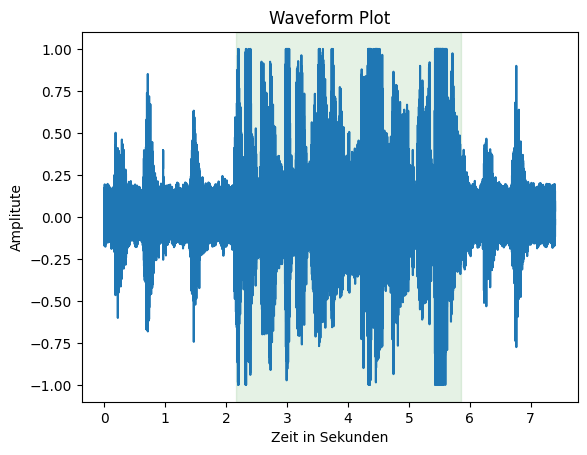

In [56]:
plot_idx = 53
tensor, sr, info = file_dataset_train[plot_idx]

#Beispiel Hardclipper
hardclipper = RandomGain(6,12)
out_hardclipper = hardclipper(tensor)

#Out
display(Audio(out_hardclipper,rate=SAMPLE_RATE))
display(plot_waveform_non_silent(out_hardclipper, get_y(tensor, sr, info), sr))

In [57]:
#XY
class SpeakDataset(Dataset):
    def __init__(self, dataset) -> None:
        super().__init__()
        self.dataset = dataset
        self.random_gain = RandomGain()
    
    def __len__(self):
            return len(self.dataset)

    @torch.no_grad()
    def __getitem__(self, idx):
        
        #Lädt x
        x, sr, info = self.dataset[idx]

        #Erzeugt y
        y = get_y(x,sr,info)

        #Random Gain
        x = self.random_gain(x)
        
        return x, y

#Chunker
class ChunkedDataset(Dataset):
    def __init__(self, dataset, sample_length = SAMPLE_LENGTH, hop_length = HOP_LENGTH, chunk_y = True) -> None:
        super().__init__()

        #unchunked Dataset
        self.dataset = dataset

        #Chunker Parameter
        self.sample_length = sample_length
        self.hop_length    = hop_length

        #Chunk Y
        self.chunk_y = chunk_y
    
    def __len__(self):
            return len(self.dataset)

    @torch.no_grad()
    def __getitem__(self, idx):
        
        #Lädt x, y für 
        x, y = self.dataset[idx]

        #Erzeugt X
        x = get_samples(x, self.sample_length, self.hop_length)

        #Erzeugt y
        if self.chunk_y:
            y = get_samples(y, self.sample_length, self.hop_length)
            y = y.sum(dim=-1).gt_(0)

        return x, y, idx


In [58]:
#SpeakDataset
speak_train_dataset_unchunked = SpeakDataset(file_dataset_train)

#ChunkedDataset
speak_train_dataset = ChunkedDataset(speak_train_dataset_unchunked)

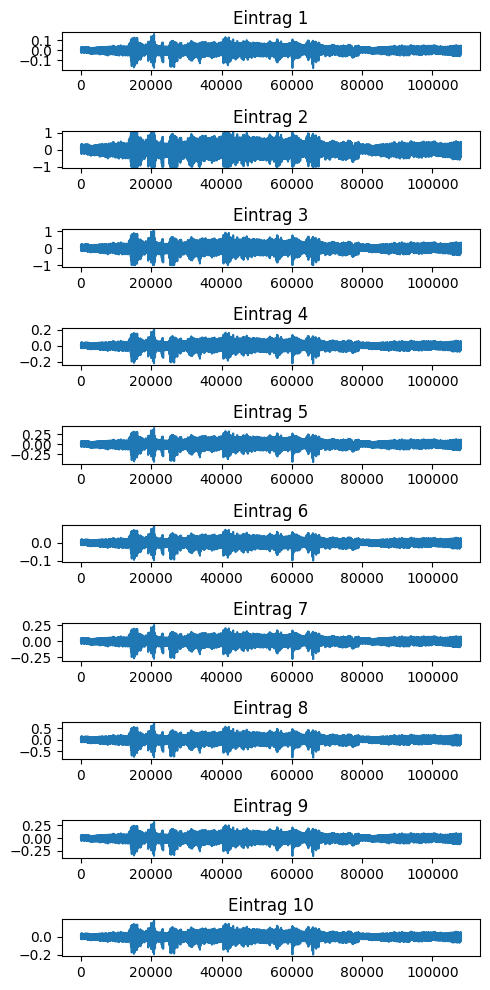

In [63]:
#Plot
_num_plots = 10
_plot_idx  = 0
fig = plt.figure(figsize=(5,_num_plots))

#Random

#Iterriert
for i in range(_num_plots):

    #Plottet
    x, y = speak_train_dataset_unchunked[_plot_idx]
    ax = plt.subplot2grid((_num_plots, 1), (i, 0), fig=fig)
    ax.plot(x)

    ax.set_title(f"Eintrag {i + 1}")

#Plot
fig.tight_layout()

In [60]:
def reverse_unfold(tensor, sample_length = SAMPLE_LENGTH, hop_length = HOP_LENGTH):
    
    #Sichert das der Übergebense Tensor die Form[Datenpunkt]
    if len(tensor.shape) != 2:
        raise Exception("BAD TENSOR SHAPE")
    
    #liest variable aus
    rows                 = tensor.size(0)
    cols                 = tensor.size(1)
    tensor_sample_length = (rows - 1) * hop_length + sample_length

    #Erzeugt padding zwischen den Einträgen, flattet den Tensor und sorgt so für einen Versatz
    pad      = tensor_sample_length - cols + hop_length
    reversed = F.pad(tensor, (0, pad), "constant", value=0)
    reversed = reversed.flatten()[:rows * tensor_sample_length].reshape(rows, tensor_sample_length)
    reversed = reversed.sum(0)

    #Summe von reversed muss durch Anzahl der Elemente geteilt werden
    num_entries = torch.ones_like(tensor,dtype=torch.float)
    num_entries = F.pad(num_entries, (0, pad), "constant", value=0)
    num_entries = num_entries.flatten()[:rows * tensor_sample_length].reshape(rows, tensor_sample_length)
    num_entries = num_entries.sum(0)

    #Erzeugt Samples
    return torch.div(reversed,num_entries)

In [64]:
@torch.no_grad()
def plot_model_result(x, y = None, prediction = None, ax = None, y_axis_0dbfs_scale = False):
    
    #Für Mulitplot
    direct_plot = False

    #für direktem Plot
    if ax == None:
        ax = plt.gca()
        direct_plot = True

    #Plottet Waveform
    waveform  = reverse_unfold(x)
    time_axis = np.arange(0, len(waveform))
    ax.plot(time_axis, waveform, color="blue")
    
    #Skaliert y zwischen -1 und 1
    if y_axis_0dbfs_scale:
        ax.set_ylim(-1,1)

    #Plot für Non-Silent
    if y != None:
        for start, end in get_parts(y):
            ax.axvspan(
                xmin = start * HOP_LENGTH,
                xmax = end   * HOP_LENGTH + SAMPLE_LENGTH,
                alpha=0.2,color="green", lw=0,
                ymax=0.5,
                label="Sprache"
            )
    
    #Plot für Model Prediction
    if prediction != None:
        for start, end in get_parts(prediction):
            ax.axvspan(
                xmin = start * HOP_LENGTH,
                xmax = end   * HOP_LENGTH + SAMPLE_LENGTH,
                alpha=0.2,color="red", lw=0,
                ymin=0.5,
                label="Vorhersage",
            )
    
    if direct_plot:
        plt.xlabel("Sample")
        plt.ylabel("Amplitute")
        plt.title("Vorhersage")
        plt.show()

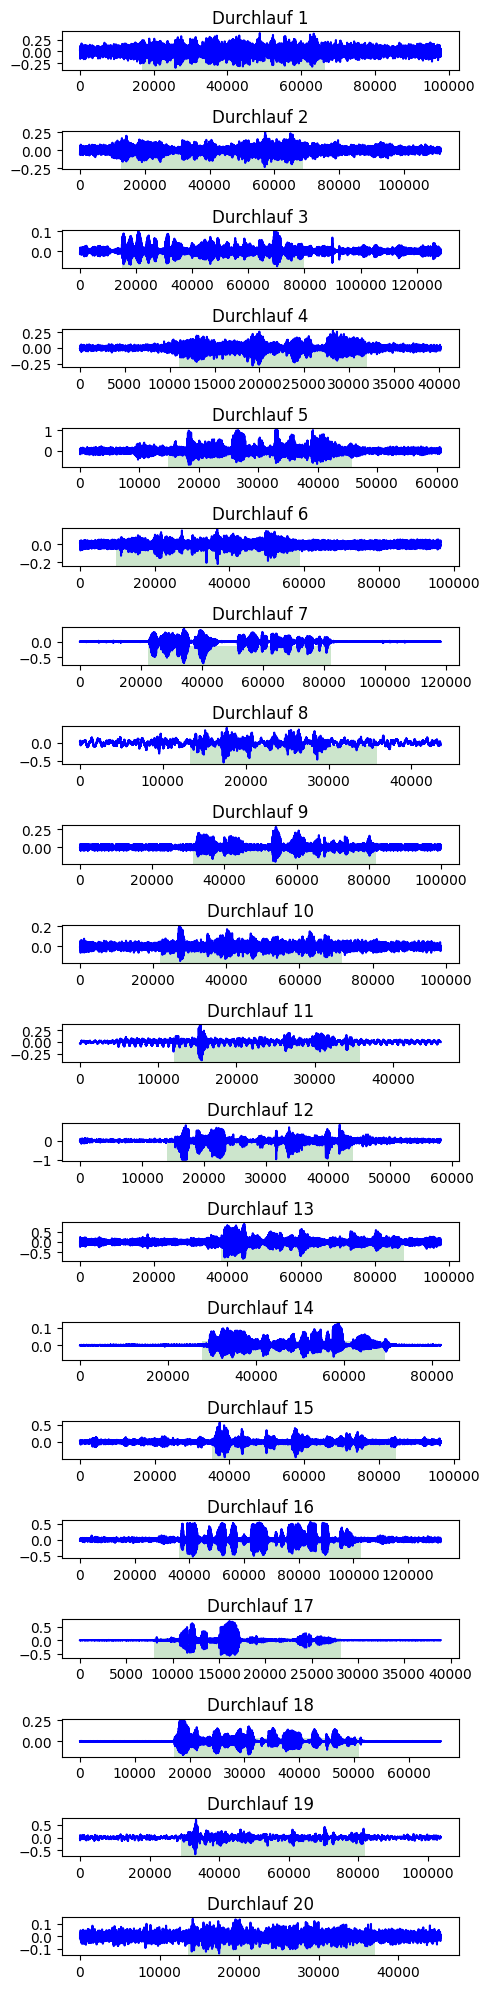

In [67]:
_num_plots = 20

#Plot
fig = plt.figure(figsize=(5,_num_plots))

#Iterriert
for i in range(_num_plots):
    
    #Plottet
    x, y, _ = speak_train_dataset[ np.random.randint(0,len(speak_train_dataset)) ]

    ax = plt.subplot2grid((_num_plots, 1), (i, 0), fig=fig)
    plot_model_result(x,y,ax=ax)

    ax.set_title(f"Durchlauf {i + 1}")

#Plot
fig.tight_layout()


In [69]:
def costume_collate_fn(batch):
    
    sample_list = []
    x_list      = []
    y_list      = []
    
    #Get Data
    for x, y, n in batch:

        x_list.append(x)
        y_list.append(y)
        
        #Für Zuordnung
        sample_list.append(torch.ones_like(y) * n)

    return torch.hstack(sample_list), torch.vstack(x_list), torch.hstack(y_list)

dataloader_train = DataLoader(speak_train_dataset, batch_size=16, shuffle=True, collate_fn=costume_collate_fn, pin_memory=True, num_workers=0)

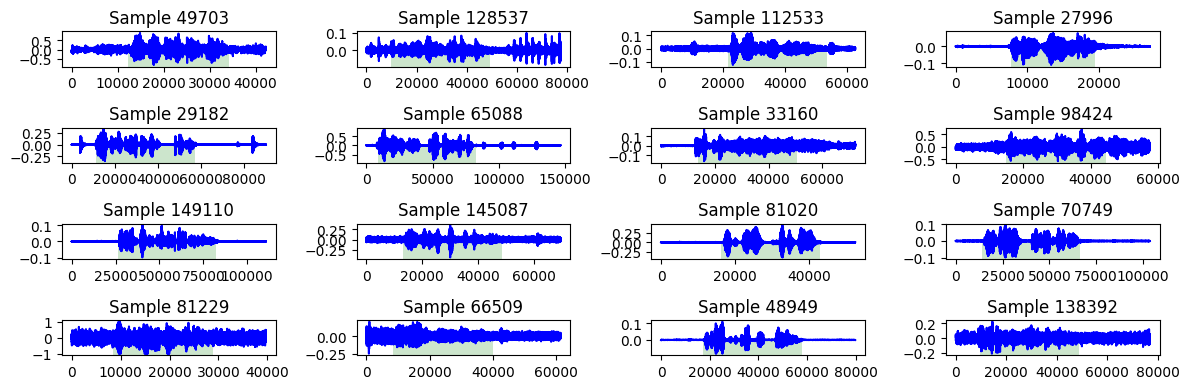

In [70]:
def plot_batch(sample, x, y, prediction=None):
    
    #Pandas
    sample = pd.Series(sample,dtype=int)

    #Plot Layout
    X_AXIS_LEN = 4
    Y_AXIS_LEN = math.ceil( len(sample.unique()) / X_AXIS_LEN)

    #Plot
    fig = plt.figure(figsize = (3 * X_AXIS_LEN, 1 * Y_AXIS_LEN))
    
    for counter, n in enumerate(sample.drop_duplicates(keep='first')):
        
        #Axis
        curr_x  = counter % X_AXIS_LEN
        curr_y  = counter // X_AXIS_LEN
        curr_ax = plt.subplot2grid((Y_AXIS_LEN, X_AXIS_LEN), (curr_y, curr_x), fig=fig)

        #Idx
        idx        = sample[sample == n].index
        first_idx  = idx.min()
        last_idx   = idx.max()

        #Params for Plot
        plot_x    = x[first_idx: last_idx + 1]
        plot_y    = y[first_idx: last_idx + 1]
        plot_pred = prediction[first_idx: last_idx + 1] if prediction != None else None
        
        #Subplot
        plot_model_result(plot_x, plot_y, plot_pred, ax=curr_ax)
        curr_ax.set_title(f"Sample {n}")
    
    #Plot
    fig.tight_layout()

#Test
sample, x, y = next(iter(dataloader_train))
plot_batch(sample, x, y)

In [71]:
#erhöht Batch Size
dataloader_train = DataLoader(speak_train_dataset, batch_size=128, shuffle=True, collate_fn=costume_collate_fn, pin_memory=True, num_workers=0) 

#Variblen zur Messung
N_BATCHES = 5

#Speedcheck
start = time.time()
curr_time = time.time()

for idx, (sample, x, y) in enumerate(dataloader_train):
    
    #Batch
    batch = idx + 1

    #Aktualisiert Zeit
    curr_time = time.time()
    
    #Print
    print(f"Batch {batch}: ", "{:.2f}".format((curr_time - start) / (idx + 1)), " s")

    #Loop
    if batch >= N_BATCHES:
        break

Batch 1:  1.64  s
Batch 2:  1.60  s
Batch 3:  1.56  s
Batch 4:  1.52  s
Batch 5:  1.59  s


In [72]:
model, util = torch.hub.load(
    repo_or_dir='snakers4/silero-vad',
    model='silero_vad',
    force_reload=True,
    trust_repo=False
)

#EVAL
model = model.eval()

The repository is already trusted.


Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to C:\Users\Jonas/.cache\torch\hub\master.zip


In [73]:
#Vergleich von Frames schlecht, da so keine Überlappungen berücksichtigt werden

#Imports
import torchmetrics

#Variablen
_numb_samples = 512

#Accuracy
accuracy = torchmetrics.classification.BinaryAccuracy()

#Erstellt eigenes ChunkedDataset für Test
#TODO FIX!!!!
speak_test_dataset_silerio = ChunkedDataset(speak_train_dataset_unchunked, SAMPLE_LENGTH, SAMPLE_LENGTH, False)

#Samples zum Testen
idx = np.arange(0, len(speak_test_dataset_silerio))
np.random.shuffle(idx)
idx = idx[:_numb_samples]

#Ergebnis
pred_total = []
y_total    = []

#Iterriert über Sample
with torch.no_grad():
        
        #Iterriert Sample
        for i in idx:

                #Lädt Sample
                x, y, idx = speak_test_dataset_silerio[i]

                
                #Reset Model
                model.reset_states()

                #Prediction
                pred = torch.zeros_like(y)

                #Iterriert Samples
                for pos, chunk in enumerate(x):
                        
                        start_pos = pos * chunk.size(-1)
                        end_pos   = start_pos + chunk.size(-1)
                        pred[start_pos : end_pos] = model(chunk, SAMPLE_RATE).item()
                
                #Fügt Total an
                pred_total.append(pred)
                y_total.append(y)

#Tensor
y_total    = torch.hstack(y_total)
pred_total = torch.hstack(pred_total)

#Print für Accuracy
print("Accuracy auf Batch:", accuracy(pred_total, y_total))

C:\Users\Jonas\AppData\Roaming\Python\Python39\site-packages\torch\nn\modules\module.py:1501: UserWarning: operator () profile_node %668 : int[] = prim::profile_ivalue(%666)
 does not have profile information (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\third_party\nvfuser\csrc\graph_fuser.cpp:108.)
  return forward_call(*args, **kwargs)


Accuracy auf Batch: tensor(0.8947)


In [74]:
class Net(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(SAMPLE_LENGTH, 512)
        self.fc2 = nn.Linear(512,64)
        self.fc3 = nn.Linear(64,64)
        self.fc4 = nn.Linear(64,64)
        self.fc5 = nn.Linear(64,1)
    
    def forward(self, x):
        
        #forward
        out = torch.relu(self.fc1(x))
        out = torch.relu(self.fc2(out))
        out = torch.relu(self.fc3(out))
        out = torch.relu(self.fc4(out))
        out = torch.sigmoid(self.fc5(out))

        return out.view(out.shape[0])

In [75]:
# KONSTANTEN
N_BATCHES = 800
N_BATCHES_PLOT = 100

#GPU
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

#CPU für debugging
#device = torch.device("cpu")

#Instanz des Models
model     = Net().to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn   = nn.BCELoss()

#counters
epoch_counter = 0
batch_counter = 0

with torch.set_grad_enabled(True):

    while True:

        loss_train = 0.0

        for sample, x, y in dataloader_train:

            #GPU
            x = x.to(device=device)
            y = y.to(device=device)

            #enable autograd
            x.requires_grad = True
            y.requires_grad = True

            #Forward
            output = model(x)

            #Loss
            loss = loss_fn(output, y)
    
            #Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

            #BATCH COUNTER
            batch_counter +=1
            
            #Print
            if batch_counter == 1 or batch_counter %N_BATCHES_PLOT == 0:
                print(f"{datetime.datetime.now()} Batch {batch_counter} Epoch {epoch_counter} Loss on Batch: {loss.item()}")

            #END
            if batch_counter >= N_BATCHES:
                break
        
        #Sucessfull Epoch
        else:
            epoch_counter += 1
            continue

        #END
        break

2023-04-21 00:56:29.260265 Batch 1 Epoch 0 Loss on Batch: 0.6931496262550354
2023-04-21 00:59:32.572991 Batch 100 Epoch 0 Loss on Batch: 0.5646654367446899
2023-04-21 01:02:49.981741 Batch 200 Epoch 0 Loss on Batch: 0.526963472366333
2023-04-21 01:05:49.985747 Batch 300 Epoch 0 Loss on Batch: 0.5300672650337219
2023-04-21 01:09:03.409897 Batch 400 Epoch 0 Loss on Batch: 0.5167605876922607
2023-04-21 01:12:42.452961 Batch 500 Epoch 0 Loss on Batch: 0.5190780162811279
2023-04-21 01:16:59.110201 Batch 600 Epoch 0 Loss on Batch: 0.5447463989257812
2023-04-21 01:21:52.635262 Batch 700 Epoch 0 Loss on Batch: 0.49287092685699463
2023-04-21 01:27:39.449513 Batch 800 Epoch 0 Loss on Batch: 0.49725842475891113


In [ ]:
#Mit Batchnorm
class Net(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(SAMPLE_LENGTH, 512)
        self.fc2 = nn.Linear(512,64)
        self.fc3 = nn.Linear(64,64)
        self.fc4 = nn.Linear(64,64)
        self.fc5 = nn.Linear(64,1)
    
    def forward(self, x):
        
        #Batchnorm
        x = x / x.abs().max()

        #forward
        out = torch.relu(self.fc1(x))
        out = torch.relu(self.fc2(out))
        out = torch.relu(self.fc3(out))
        out = torch.relu(self.fc4(out))
        out = torch.sigmoid(self.fc5(out))

        return out.view(out.shape[0])

In [ ]:
# KONSTANTEN
N_BATCHES = 200
N_BATCHES_PLOT = 100

#GPU
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

#CPU für debugging
device = torch.device("cpu")

#Instanz des Models
model     = Net().to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn   = nn.BCELoss()

#counters
epoch_counter = 0
batch_counter = 0

while True:

    loss_train = 0.0

    for sample, x, y in dataloader_train:
        
        #GPU
        x = x.to(device=device)
        y = y.to(device=device)

        #enable autograd
        x.requires_grad = True
        y.requires_grad = True

        #Forward
        output = model(x)

        #Loss
        loss = loss_fn(output, y)
 
        #Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_train += loss.item()

        #BATCH COUNTER
        batch_counter +=1
        
        #Print
        if batch_counter == 1 or batch_counter %N_BATCHES_PLOT == 0:
            print(f"{datetime.datetime.now()} Batch {batch_counter} Epoch {epoch_counter} Loss on Batch: {loss.item()}")

        #END
        if batch_counter >= N_BATCHES:
            break
    
    #Sucessfull Epoch
    else:
        epoch_counter += 1
        continue

    #END
    break


In [ ]:
#Exportiert Model
torch.save(model.state_dict(), "simpleMLP.model")

In [ ]:
#lädt Model
model = Net()
model.load_state_dict(torch.load("simpleMLP.model"))
model = model.eval()

In [ ]:
#Erstellt Datenloader für Test
dataloader_test  = DataLoader(speak_test_dataset,  batch_size=128,  shuffle=True, collate_fn=costume_collate_fn )


sample, x, y = next(iter(dataloader_test))
pred = model(x)

#Print für Accuracy
print("Accuracy auf Batch:", accuracy(pred,y))

#Plot
plot_batch(sample, x, y, model(x))

In [ ]:
#Lädt Sample
check_idx = 410

check_x = x[sample == check_idx]
check_y = y[sample == check_idx]
check_waveform    = reverse_unfold(check_x)


display(Audio(check_waveform,rate=SAMPLE_RATE))
display(plot_model_result(check_x,check_y,model(check_x)))

In [ ]:
#KONSTANTE
DECIBEL_LOW_TRESHOLD = 60

#WINDOW für FFT
SPEC_WINDOW = torch.hann_window(SAMPLE_LENGTH)

#Returnt Frequenzanteile
def get_frequencyspectrum(waveform, window = SPEC_WINDOW, low_treshold = -DECIBEL_LOW_TRESHOLD):
    magnitude_spec         = torch.abs(torch.fft.rfft(window * waveform)).mul_(2)       # Multiplikation mit 2 da negtiver Teil des Spektrums fehlt
    magnitude_scaled_spec  = magnitude_spec.div_(torch.sum(window))                     # Skaliert durch Summe von SPEC_WINDOW
    db_spec                = torch.log10_(magnitude_scaled_spec).mul_(20)               # Rechnet in dbFS um
    db_spec[db_spec < low_treshold] = low_treshold                                      # Minimum = Treshhold
    return db_spec

#Class
class STFT(nn.Module):
    def __init__(self, window = SPEC_WINDOW, window_trainable = False) -> None:
        
        #Init
        super().__init__()

        #Parameter
        if window_trainable:

            window = nn.Parameter(window, requires_grad = window_trainable)
            self.register_parameter("window", window)
        
        else:
            self.register_buffer("window", window)


    def forward(self, x, normalize=True):
        #Errechnet Spec
        spec = get_frequencyspectrum(x, self.window)

        #Normalisiert
        if normalize:
            return (spec + DECIBEL_LOW_TRESHOLD) / DECIBEL_LOW_TRESHOLD
        
        #nicht normalisiert
        return spec

In [ ]:
from matplotlib.ticker import ScalarFormatter

#Plot
def plot_frequencyspectrum(waveform, window = SPEC_WINDOW):

    #X - Achse
    frequencies = torch.fft.rfftfreq(SAMPLE_LENGTH,d=1/16000)

    #Y-Achse
    spec = get_frequencyspectrum(waveform, window)

    #Plot
    fig, ax = plt.subplots()
    ax.plot(frequencies,spec)
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(ScalarFormatter())
    plt.title("Periodogram")
    plt.xlabel("Frequenz in Hz")
    plt.ylabel("Decibel")
    plt.ylim((-DECIBEL_LOW_TRESHOLD,0))
    plt.show()

In [ ]:
#Lädt Daten
x, _, _ = speak_train_dataset[76]
x = x[60]

plot_frequencyspectrum(x)

In [ ]:
class Net(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        #STFT
        self.stft = STFT()
        
        #FeedForward
        self.fc1 = nn.Linear(len(torch.fft.rfftfreq(SAMPLE_LENGTH,d=1/16000)), 512)
        self.fc2 = nn.Linear(512,64)
        self.fc3 = nn.Linear(64,64)
        self.fc4 = nn.Linear(64,1)
    
    def forward(self, x):


        #forward
        out = self.stft(x)
        
        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))
        out = torch.relu(self.fc3(out))
        out = torch.sigmoid(self.fc4(out))

        return out.view(out.shape[0])

In [ ]:
#erhöht Batch Size
dataloader_train = DataLoader(speak_train_dataset, batch_size=64, shuffle=True, collate_fn=costume_collate_fn, pin_memory=True, num_workers=0) 

In [ ]:
# KONSTANTEN
N_BATCHES = 200
N_BATCHES_PLOT = 20

#GPU
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

#CPU für debugging
device = torch.device("cpu")

#Instanz des Models
model     = Net().to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn   = nn.BCELoss()

#counters
epoch_counter = 0
batch_counter = 0

while True:

    loss_train = 0.0

    for sample, x, y in dataloader_train:
        
        #GPU
        x = x.to(device=device)
        y = y.to(device=device)

        #enable autograd
        x.requires_grad = True
        y.requires_grad = True

        #Forward
        output = model(x)

        #Loss
        loss = loss_fn(output, y)
 
        #Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_train += loss.item()

        #BATCH COUNTER
        batch_counter +=1
        
        #Print
        if batch_counter == 1 or batch_counter %N_BATCHES_PLOT == 0:
            print(f"{datetime.datetime.now()} Batch {batch_counter} Epoch {epoch_counter} Loss on Batch: {loss.item()}")

        #END
        if batch_counter >= N_BATCHES:
            break
    
    #Sucessfull Epoch
    else:
        epoch_counter += 1
        continue

    #END
    break

In [ ]:
#Exportiert Model
torch.save(model.state_dict(), "stftMLP.model")

In [ ]:
#lädt Model
model = Net()
model.load_state_dict(torch.load("stftMLP.model"))
model = model.eval()

In [ ]:
#Erstellt Datenloader für Test
dataloader_test  = DataLoader(speak_test_dataset,  batch_size=128,  shuffle=True, collate_fn=costume_collate_fn )


sample, x, y = next(iter(dataloader_test))
pred = model(x)

#Print für Accuracy
print("Accuracy auf Batch:", accuracy(pred,y))

#Plot
plot_batch(sample, x, y, model(x))

In [ ]:
class Compressor(nn.Module):
    def __init__(self, treshold = -20, ratio = 4, input_gain = 0, out_gain = 0, trainable=True) -> None:
        
        #Init
        super().__init__()

        #Converting Params
        treshold   = db_to_amp(torch.tensor(treshold))
        ratio      = torch.tensor(1 / ratio)
        input_gain = db_to_amp(torch.tensor(input_gain))
        out_gain   = db_to_amp(torch.tensor(out_gain))
    
        #Treshold
        treshold = nn.Parameter(treshold, requires_grad = trainable)
        self.register_parameter("treshold", treshold)

        #Ratio
        ratio = nn.Parameter(ratio, requires_grad = trainable)
        self.register_parameter("ratio", ratio)
        
        #Input Gain
        input_gain = nn.Parameter(input_gain, requires_grad = trainable)
        self.register_parameter("input_gain", input_gain)

        #Out Gain
        out_gain = nn.Parameter(out_gain, requires_grad = trainable)
        self.register_parameter("out_gain", out_gain)
    
    def forward(self, x):

        #Input Gain
        x = x * self.input_gain

        #Berechnet Mask
        treshold_db    = amp_to_db (self.treshold)
        x_db           = amp_to_db (x.abs())
        mask           = x_db > treshold_db
        
        #Wendet Compression an
        affected_rows_in_db  = x_db[mask]
        affected_rows_out_db = treshold_db + (affected_rows_in_db - treshold_db) * self.ratio
        gain_reduction       = affected_rows_out_db - affected_rows_in_db
        factor               = db_to_amp(gain_reduction)
        x[mask]              *= factor
        
        #Out Gain
        x = x * self.out_gain

        #Returnt x
        return x
            

In [ ]:
#Plot
_tresh = -10

#Data
x,y,n = speak_train_dataset[100]


comp = Compressor(treshold=_tresh, ratio=2)
x_comp = comp(x)

waveform_original = reverse_unfold(x)
waveform_comp     = reverse_unfold(x_comp).detach()

plt.plot(waveform_original, color="blue", label="Original")
plt.plot(waveform_comp,     color="orange", label="Komprimiert")
plt.axhline(y= db_to_amp(_tresh), color="red")
plt.axhline(y= db_to_amp(_tresh) * -1, color="red")
plt.legend()
plt.title("Compressor")

In [ ]:
class Net(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        #COMP
        self.compressor = Compressor(treshold= -10,  ratio=2, input_gain=6)
        self.limiter    = Compressor(treshold= -0.1, ratio=100)

        #STFT
        self.stft = STFT()
        
        #FeedForward
        self.fc1 = nn.Linear(len(torch.fft.rfftfreq(SAMPLE_LENGTH,d=1/16000)), 512)
        self.fc2 = nn.Linear(512,64)
        self.fc3 = nn.Linear(64,64)
        self.fc4 = nn.Linear(64,1)
    
    def forward(self, x):


        #forward
        out = self.compressor(x)
        out = self.limiter(x)

        out = self.stft(x)
        
        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))
        out = torch.relu(self.fc3(out))
        out = torch.sigmoid(self.fc4(out))

        return out.view(out.shape[0])

In [ ]:
#erhöht Batch Size
dataloader_train = DataLoader(speak_train_dataset, batch_size=64, shuffle=True, collate_fn=costume_collate_fn, pin_memory=True, num_workers=0)

In [ ]:
# KONSTANTEN
N_BATCHES = 400
N_BATCHES_PLOT = 20

#GPU
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

#CPU für debugging
device = torch.device("cpu")

#Instanz des Models
model     = Net().to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn   = nn.BCELoss()

#counters
epoch_counter = 0
batch_counter = 0

while True:

    loss_train = 0.0

    for sample, x, y in dataloader_train:
        
        #GPU
        x = x.to(device=device)
        y = y.to(device=device)

        #enable autograd
        x.requires_grad = True
        y.requires_grad = True

        #Forward
        output = model(x)

        #Loss
        loss = loss_fn(output, y)
 
        #Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_train += loss.item()

        #BATCH COUNTER
        batch_counter +=1
        
        #Print
        if batch_counter == 1 or batch_counter %N_BATCHES_PLOT == 0:
            print(f"{datetime.datetime.now()} Batch {batch_counter} Epoch {epoch_counter} Loss on Batch: {loss.item()}")

        #END
        if batch_counter >= N_BATCHES:
            break
    
    #Sucessfull Epoch
    else:
        epoch_counter += 1
        continue

    #END
    break